In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm

from scipy.io import loadmat

In [51]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract values from the first column into two arrays
healthy_sample = df_raw[df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

# Extract AAL source names
cser_values = loadmat("cser_values.mat")
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]

In [4]:
# Load EEG source data from -v7.3 .mat file
eeg_source = h5py.File('eeg_source.mat', 'r')

eeg_source_open = eeg_source['eeg_source_open']
eeg_source_closed = eeg_source['eeg_source_closed']

def get_eeg_list(eeg_source, sample_list):
    eeg_keys = eeg_source.keys()
    return [eeg_source[f'x{sample}'] for sample in sample_list if f'x{sample}' in eeg_keys]

eeg_source_open_healthy = get_eeg_list(eeg_source_open, healthy_sample)
eeg_source_open_depressed = get_eeg_list(eeg_source_open, depressed_sample)
eeg_source_closed_healthy = get_eeg_list(eeg_source_closed, healthy_sample)
eeg_source_closed_depressed = get_eeg_list(eeg_source_closed, depressed_sample)

In [ ]:
def lzc_prep(eeg_source):
    all_subjects = []

    for i, subj_data in enumerate(eeg_source):
        if i % 10 == 0:
            print(f"Processing {i+1}/{len(eeg_source)}")
        subj_data = np.array(subj_data)  # shape: (samples, sources, trials)
        subj_srcs = []

        for src in range(60):
            # Reshape: concatenate across trials for the current source
            data_1d = subj_data[:, src, :].reshape(-1)
            
            # Binarize by median thresholding
            threshold = np.median(data_1d)
            binary_seq = (data_1d > threshold).astype(int)

            # Split into 4s epochs (sr = 500Hz)
            segment_length = 4 * 500
            n_segments = len(binary_seq) // segment_length
            subj_segments = [binary_seq[i*segment_length:(i+1)*segment_length] for i in range(n_segments)]

            subj_srcs.append(subj_segments)

        all_subjects.append(subj_srcs)

    print()
    return all_subjects


prep_open_healthy = lzc_prep(eeg_source_open_healthy)
prep_open_depressed = lzc_prep(eeg_source_open_depressed)   
prep_closed_healthy = lzc_prep(eeg_source_closed_healthy)   
prep_closed_depressed = lzc_prep(eeg_source_closed_depressed)   

In [ ]:
# Took 588 minutes = 9.8 hours

from lz76.lz76 import LZ76

# def calc_er(X):
#     lz = LZ76(X) # Compute Lempel-Ziv complexity
#     er = lz*np.log2(len(X))/len(X) # Normalize using log2(length)
#     return er

def compute_lz76(prep_data):
    """
    Computes LZ76 complexity for each segment in prep_data.
    Returns:
        lz76_per_subject_source: list of lists (subject, source mean)
        lz76_per_subject: list (subject mean)
        lz76_overall: float (overall mean)
    """
    lz76_per_subject_source = []
    lz76_per_subject = []

    for i, subj in enumerate(prep_data):
        subj_sources = []

        for j, src in enumerate(subj):
            if j % 10 == 0:
                print(f"Processing {i+1}/{len(prep_data)} subject's {j+1}/{len(subj)} source")
            # Calculating LZC per subject/source/segment
            src_seg_lz = [LZ76(seg) for seg in src if len(seg) > 0]
            # Calculating LZC per subject/source
            subj_sources.append(np.nanmean(src_seg_lz))
        
        lz76_per_subject_source.append(subj_sources)
        # Calculating LZC per subject
        lz76_per_subject.append(np.nanmean(subj_sources))

    # Calculating LZC overall
    lz76_overall = np.nanmean(lz76_per_subject)
    print()

    return lz76_per_subject_source, lz76_per_subject, lz76_overall


lz76_open_healthy = compute_lz76(prep_open_healthy)
lz76_open_depressed = compute_lz76(prep_open_depressed)
lz76_closed_healthy = compute_lz76(prep_closed_healthy)
lz76_closed_depressed = compute_lz76(prep_closed_depressed)

In [ ]:
# Save the four LZ76 results to a file for later retrieval
# lz76_values = {
#     'lz76_open_healthy': lz76_open_healthy,
#     'lz76_open_depressed': lz76_open_depressed,
#     'lz76_closed_healthy': lz76_closed_healthy,
#     'lz76_closed_depressed': lz76_closed_depressed
# }

# with open('lz76_values.pkl', 'wb') as f:
#     pickle.dump(lz76_values, f)

In [5]:
# Load the results from the file
lz76_values = None
with open('lz76_values.pkl', 'rb') as f:
    lz76_values = pickle.load(f)

# Unpack the results
lz76_open_healthy = lz76_values['lz76_open_healthy']
lz76_open_depressed = lz76_values['lz76_open_depressed']
lz76_closed_healthy = lz76_values['lz76_closed_healthy']
lz76_closed_depressed = lz76_values['lz76_closed_depressed']

In [8]:
region_map = {
    'frontal': [f'src{i+1:02d}_{source_names[i]}' for i in range(2, 16)] + [f'src{i:02d}_{source_names[i]}' for i in range(18, 24)],
    'occipital': [f'src{i+1:02d}_{source_names[i]}' for i in range(24, 36)],
    'parietal': [f'src{i+1:02d}_{source_names[i]}' for i in range(38, 50)],
    'sensorimotor': [f'src{i+1:02d}_{source_names[i]}' for i in [0, 1, 16, 17, 36, 37]],
    'temporal': [f'src{i+1:02d}_{source_names[i]}' for i in range(50, 60)]
}

In [52]:
# Average LZC for each source across subjects for each condition
def average_lz76_per_source(lz76_tuple):
    # lz76_tuple[0] is a list of lists: [subject][source]
    lz76_per_subject_source = lz76_tuple[0]
    # Transpose to [source][subject]
    lz76_per_source = np.array(lz76_per_subject_source).T
    # Average across subjects for each source
    return np.nanmean(lz76_per_source, axis=1)


def structure_lzc(lzc_calcs, eyes, health):

    subj_ids = healthy_sample if health == 'healthy' else depressed_sample

    lzc_subdictionary = []
    lzc_calcs_source = average_lz76_per_source(lzc_calcs)

    # average per eyes/health condition
    lzc_subdictionary.append({
        'subject': 'average',
        'eyes': eyes,
        'depressed': 1 if health == 'depressed' else 0,
        'area': 'brain',
        'lz76': lzc_calcs[2]
    })

    # average per eyes/health condition per subject
    for subj_idx, val in enumerate(lzc_calcs[1]):
        lzc_subdictionary.append({
            'subject': subj_ids[subj_idx],
            'eyes': eyes,
            'depressed': 1 if health == 'depressed' else 0,
            'area': 'brain',
            'lz76': val
        })
    
    # average per eyes/health condition per source
    for src_idx, val in enumerate(lzc_calcs_source):
        lzc_subdictionary.append({
            'subject': 'average',
            'eyes': eyes,
            'depressed': 1 if health == 'depressed' else 0,
            'area': f'src{src_idx+1:02d}_{source_names[src_idx]}',
            'lz76': val
        })
    
    # average per eyes/health condition per subject/source
    for subj_idx, subj_val in enumerate(lzc_calcs[0]):
        for src_idx, val in enumerate(subj_val):
            lzc_subdictionary.append({
                'subject': subj_ids[subj_idx],
                'eyes': eyes,
                'depressed': 1 if health == 'depressed' else 0,
                'area': f'src{src_idx+1:02d}_{source_names[src_idx]}',
                'lz76': val
            })
    
    # average per eyes/health condition per subject/region
    for subj_idx, subj_val in enumerate(lzc_calcs[0]):
        for region, srcs in region_map.items():
            region_lz76 = np.nanmean([subj_val[int(src.split('_')[0][3:])-1] for src in srcs if int(src.split('_')[0][3:])-1 < len(subj_val)])
            lzc_subdictionary.append({
                'subject': subj_ids[subj_idx],
                'eyes': eyes,
                'depressed': 1 if health == 'depressed' else 0,
                'area': region,
                'lz76': region_lz76
            })
    
    # average per eyes/health condition per region
    for region, srcs in region_map.items():
        region_lz76 = np.nanmean([lzc_calcs_source[int(src.split('_')[0][3:])-1] for src in srcs if int(src.split('_')[0][3:])-1 < len(lzc_calcs_source)])
        lzc_subdictionary.append({
            'subject': 'average',
            'eyes': eyes,
            'depressed': 1 if health == 'depressed' else 0,
            'area': region,
            'lz76': region_lz76
        })
    
    return lzc_subdictionary


lzc_dictionary = []

lzc_dictionary.extend(structure_lzc(lz76_open_healthy, 'open', 'healthy'))
lzc_dictionary.extend(structure_lzc(lz76_open_depressed, 'open', 'depressed'))
lzc_dictionary.extend(structure_lzc(lz76_closed_healthy, 'closed', 'healthy'))
lzc_dictionary.extend(structure_lzc(lz76_closed_depressed, 'closed', 'depressed'))

lzc_df = pd.DataFrame(lzc_dictionary)

# Merge lzc_df with df_raw on 'subject' and 'id' respectively
df_raw.rename(columns={'id': 'subject'}, inplace=True)
df = pd.merge(lzc_df, df_raw, on='subject', how='left')

print(lzc_df)
print(df_raw)
print(df)

       subject    eyes  depressed          area        lz76
0      average    open          0         brain  145.097647
1          507    open          0         brain  163.963333
2          508    open          0         brain  133.423392
3          509    open          0         brain  141.768155
4          510    open          0         brain  152.654000
...        ...     ...        ...           ...         ...
15967  average  closed          1       frontal  146.020663
15968  average  closed          1     occipital  133.213963
15969  average  closed          1      parietal  132.030590
15970  average  closed          1  sensorimotor  141.168034
15971  average  closed          1      temporal  149.653547

[15972 rows x 5 columns]
     subject  MDD                         MDD_note  HamD  sex   age   BDI  \
0        507   99                              NaN   NaN  1.0  19.0   0.0   
1        508   99                              NaN   NaN  1.0  18.0   4.0   
2        509   99      

### PLOTS

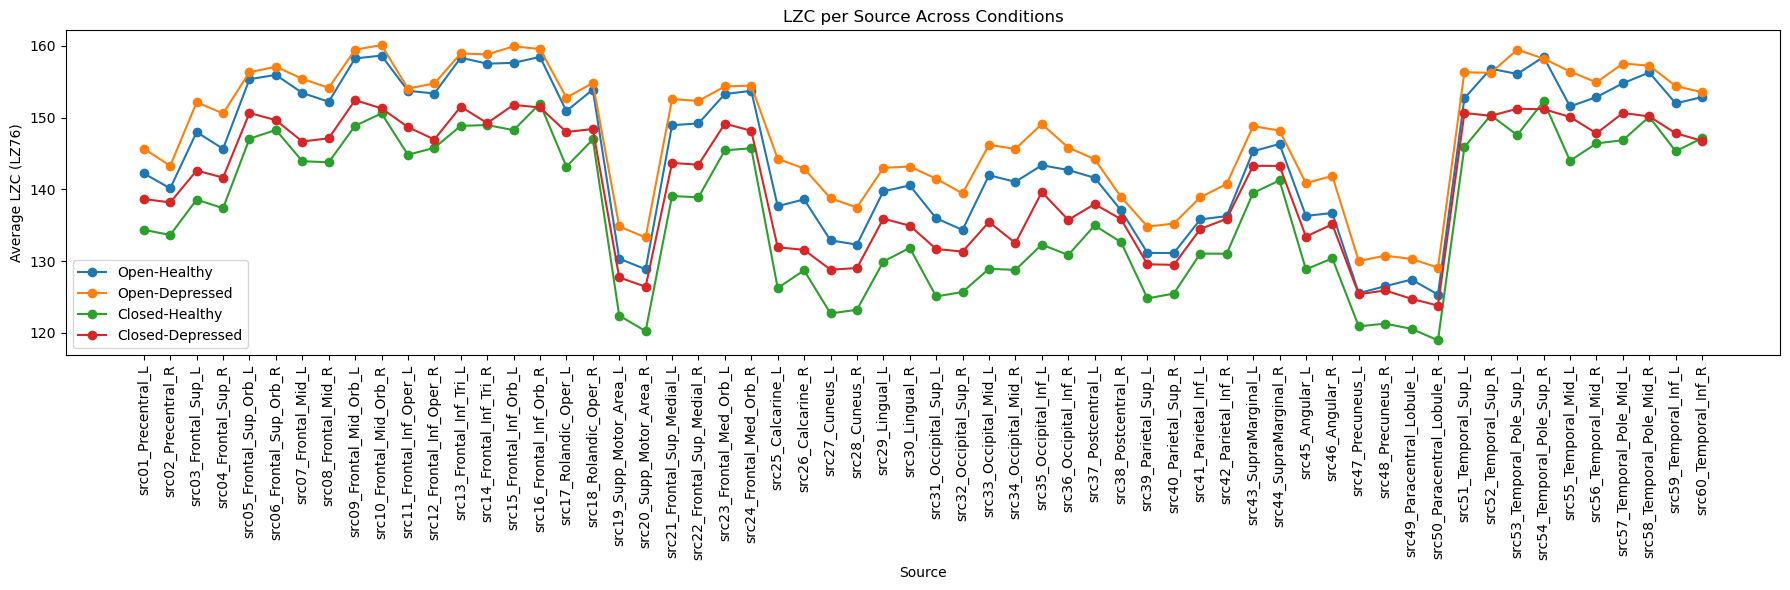

In [43]:
source_indices = np.arange(1, 61)
plt.figure(figsize=(18, 6))

for eyes in lzc_df['eyes'].unique():
    for depressed in lzc_df['depressed'].unique():
        mask = (
            (lzc_df['eyes'] == eyes) &
            (lzc_df['depressed'] == depressed) &
            (lzc_df['subject'] == 'average') &
            (lzc_df['area'].str.startswith('src'))
        )
        vals = lzc_df.loc[mask, 'lz76'].values
        label = f'{eyes.capitalize()}-{"Depressed" if depressed == 1 else "Healthy"}'
        plt.plot(source_indices, vals, marker='o', label=label)

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average LZC (LZ76)')
plt.title('LZC per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

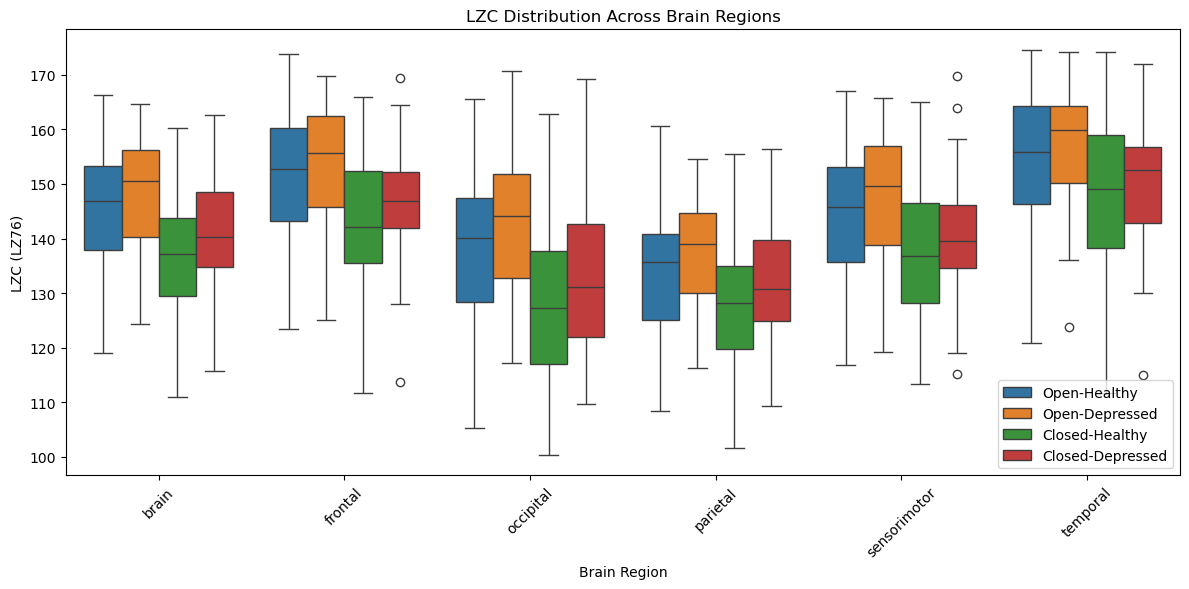

In [44]:
# Plotting CSER distribution across brain regions
mask = (lzc_df['subject'] != 'average') & (~lzc_df['area'].str.startswith('src'))
df_subset = lzc_df.loc[mask, ['area', 'lz76', 'eyes', 'depressed']].copy()
df_subset['eyes'] = df_subset['eyes'].str.capitalize()
df_subset['depressed'] = df_subset['depressed'].map({0: 'Healthy', 1: 'Depressed'})
df_subset['condition'] = df_subset['eyes'] + '-' + df_subset['depressed']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_subset, x='area', y='lz76', hue='condition')

plt.xlabel('Brain Region')
plt.ylabel('LZC (LZ76)')
plt.title('LZC Distribution Across Brain Regions')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [53]:
subset = df[(df['eyes'] == 'open') & (df['area'] == 'brain')]
print(subset)

      subject  eyes  depressed   area        lz76   MDD  \
0     average  open          0  brain  145.097647   NaN   
1         507  open          0  brain  163.963333  99.0   
2         508  open          0  brain  133.423392  99.0   
3         509  open          0  brain  141.768155  99.0   
4         510  open          0  brain  152.654000  99.0   
...       ...   ...        ...    ...         ...   ...   
5966      618  open          1  brain  144.182653  50.0   
5967      622  open          1  brain  156.250680   1.0   
5968      624  open          1  brain  151.651786   1.0   
5969      625  open          1  brain  153.375000   2.0   
5970      626  open          1  brain  149.067544   1.0   

                   MDD_note  HamD  sex   age   BDI  BDI_Anh  BDI_Mel   TAI  
0                       NaN   NaN  NaN   NaN   NaN      NaN      NaN   NaN  
1                       NaN   NaN  1.0  19.0   0.0      0.0      0.0  23.0  
2                       NaN   NaN  1.0  18.0   4.0      0.0 

In [54]:
df['depressed'] = df.iloc[:, 1].apply(lambda x: 1 if x == 1 else 0)
df['intercept'] = 1

# Perform regression analysis for each combination of eyes, area, and band
variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age']
rlm_results = pd.DataFrame(columns=['eyes', 'area', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

for eyes in ['open', 'closed']:
    for area in df['area'].unique():
        # Run sm.RLM for each subset of the DataFrame
        subset = df[(df['eyes'] == eyes) & (df['area'] == area)]
        print(subset[variables])
        if subset.empty:
            continue
        model = sm.RLM(subset['lz76'], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
        results = model.fit()
        # print(results.summary())
        for var in variables[1:]:
            p_significant = results.pvalues[var] <= 0.05
            t_significant = abs(results.tvalues[var]) >= 1.7
            new_permutation = pd.DataFrame([{
                'eyes': eyes,
                'area': area,
                'variable': var,
                'p_value': results.pvalues[var],
                't_value': results.tvalues[var],
                'p_significant': p_significant,
                't_significant': t_significant
            }])
            rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)

# print(rlm_results)

      intercept  depressed   BDI  BDI_Anh  BDI_Mel   TAI  sex   age
0             1          0   NaN      NaN      NaN   NaN  NaN   NaN
1             1          0   0.0      0.0      0.0  23.0  1.0  19.0
2             1          0   4.0      0.0      2.0  47.0  1.0  18.0
3             1          0   7.0      0.0      3.0  44.0  1.0  18.0
4             1          0   1.0      0.0      1.0  27.0  1.0  19.0
...         ...        ...   ...      ...      ...   ...  ...   ...
5966          1          0  24.0      2.0      6.0  53.0  1.0  19.0
5967          1          0  14.0      2.0      4.0  41.0  2.0  18.0
5968          1          0  23.0      4.0      6.0  60.0  1.0  20.0
5969          1          0  16.0      3.0      4.0  60.0  1.0  19.0
5970          1          0  14.0      3.0      4.0  41.0  1.0  18.0

[121 rows x 8 columns]
      intercept  depressed   BDI  BDI_Anh  BDI_Mel   TAI  sex   age
90            1          0   NaN      NaN      NaN   NaN  NaN   NaN
150           1         

C:\Users\lukad\AppData\Local\Temp\ipykernel_29592\3529696046.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


      intercept  depressed   BDI  BDI_Anh  BDI_Mel   TAI  sex   age
97            1          0   NaN      NaN      NaN   NaN  NaN   NaN
157           1          0   0.0      0.0      0.0  23.0  1.0  19.0
217           1          0   4.0      0.0      2.0  47.0  1.0  18.0
277           1          0   7.0      0.0      3.0  44.0  1.0  18.0
337           1          0   1.0      0.0      1.0  27.0  1.0  19.0
...         ...        ...   ...      ...      ...   ...  ...   ...
7538          1          0  24.0      2.0      6.0  53.0  1.0  19.0
7598          1          0  14.0      2.0      4.0  41.0  2.0  18.0
7658          1          0  23.0      4.0      6.0  60.0  1.0  20.0
7718          1          0  16.0      3.0      4.0  60.0  1.0  19.0
7778          1          0  14.0      3.0      4.0  41.0  1.0  18.0

[121 rows x 8 columns]
      intercept  depressed   BDI  BDI_Anh  BDI_Mel   TAI  sex   age
98            1          0   NaN      NaN      NaN   NaN  NaN   NaN
158           1         

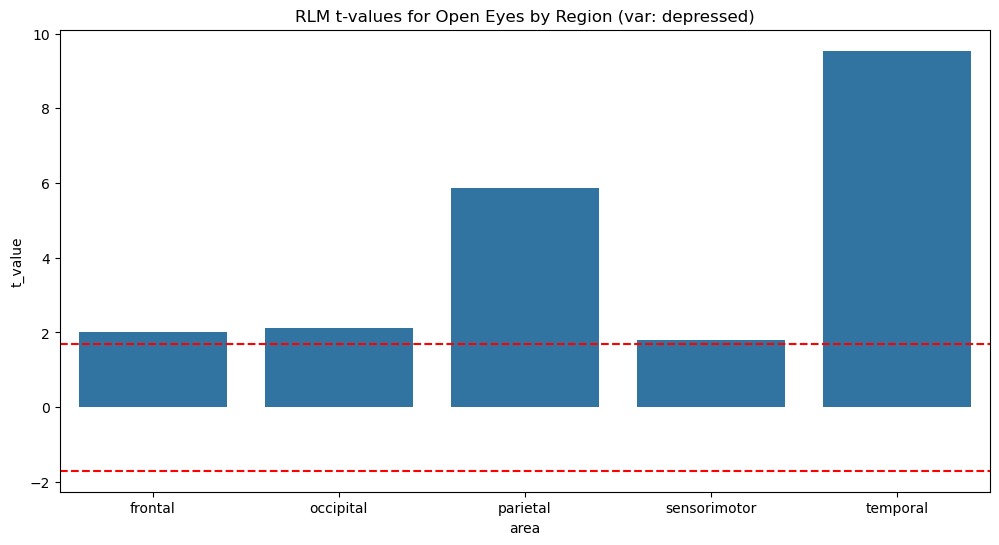

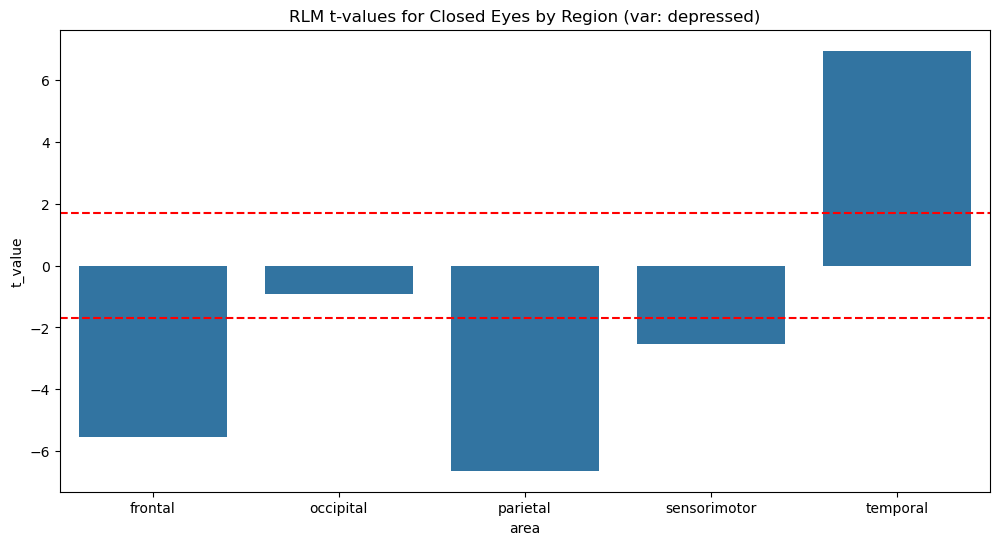

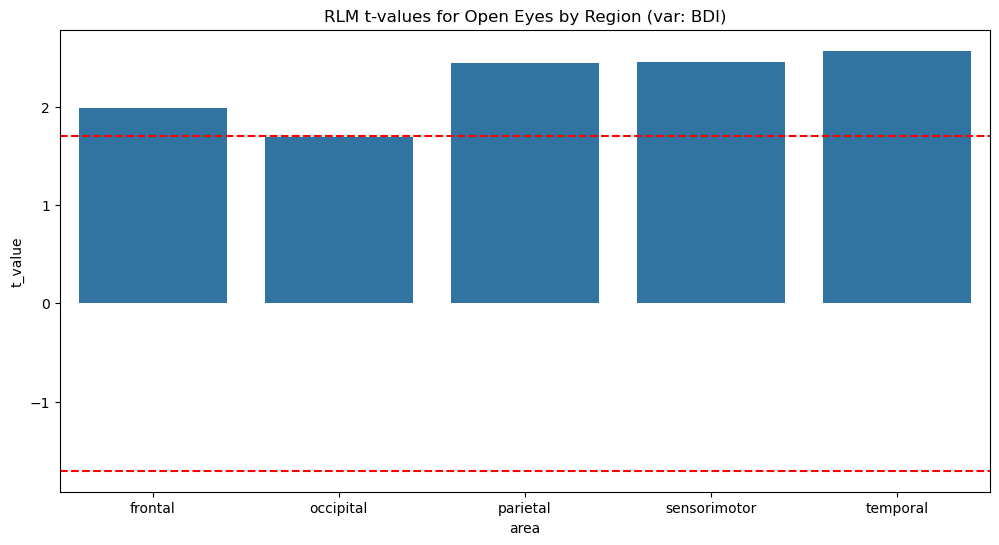

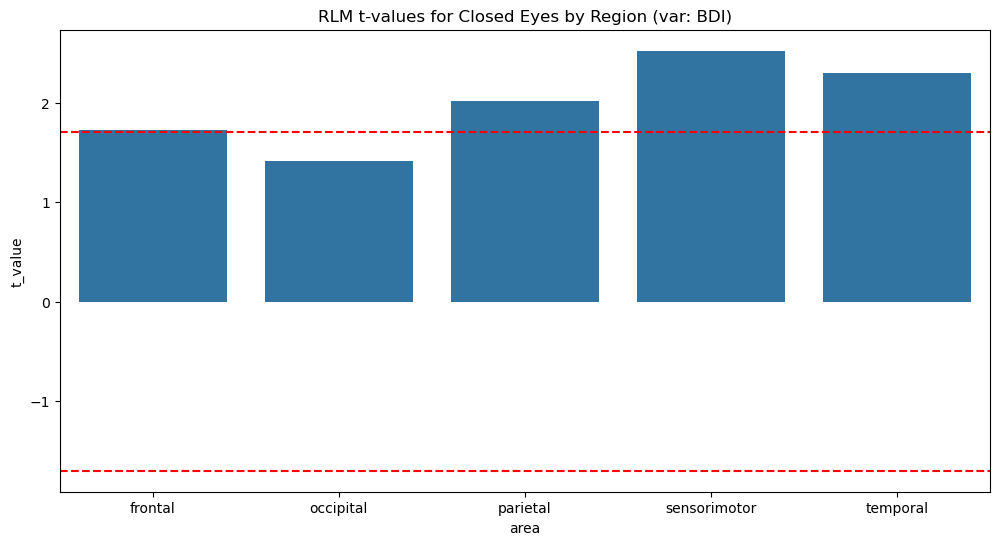

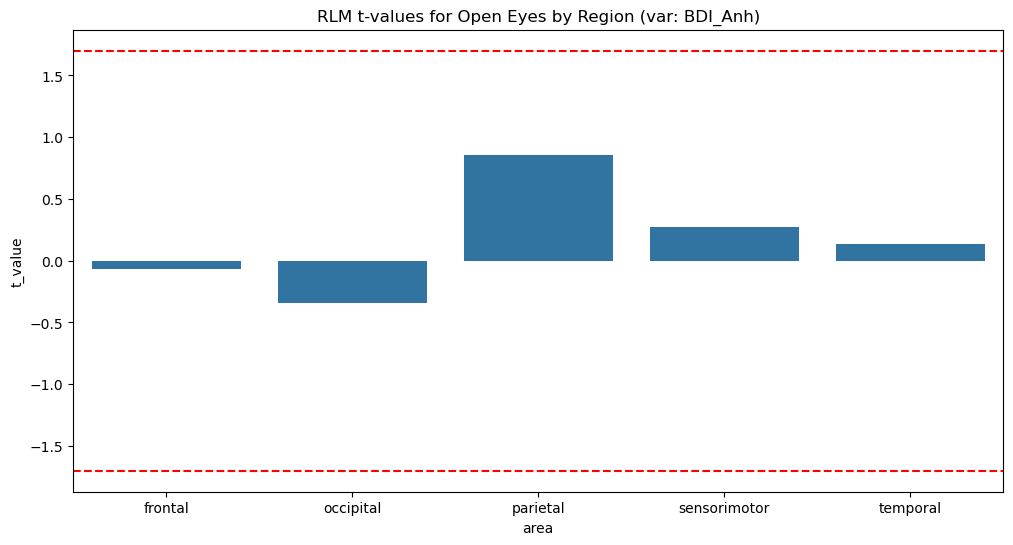

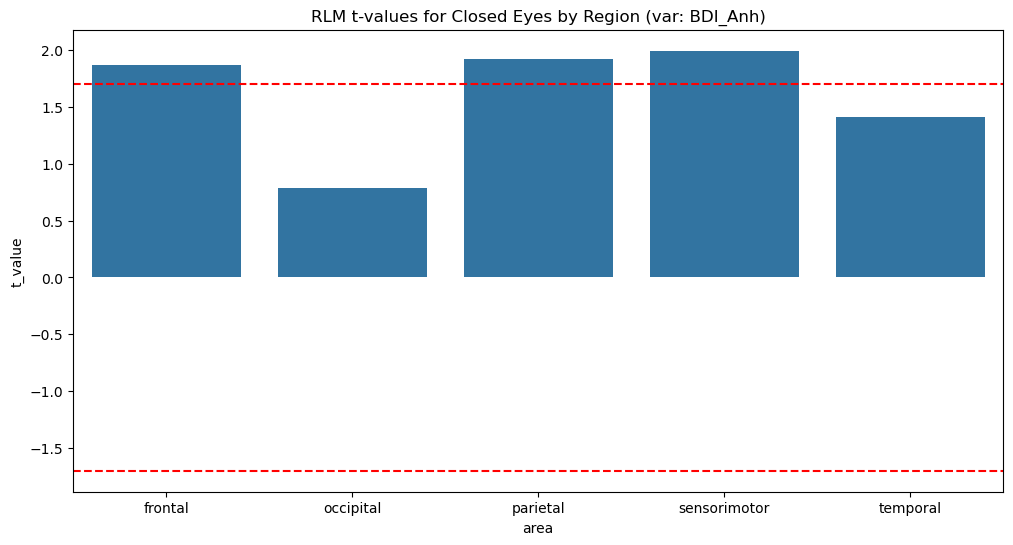

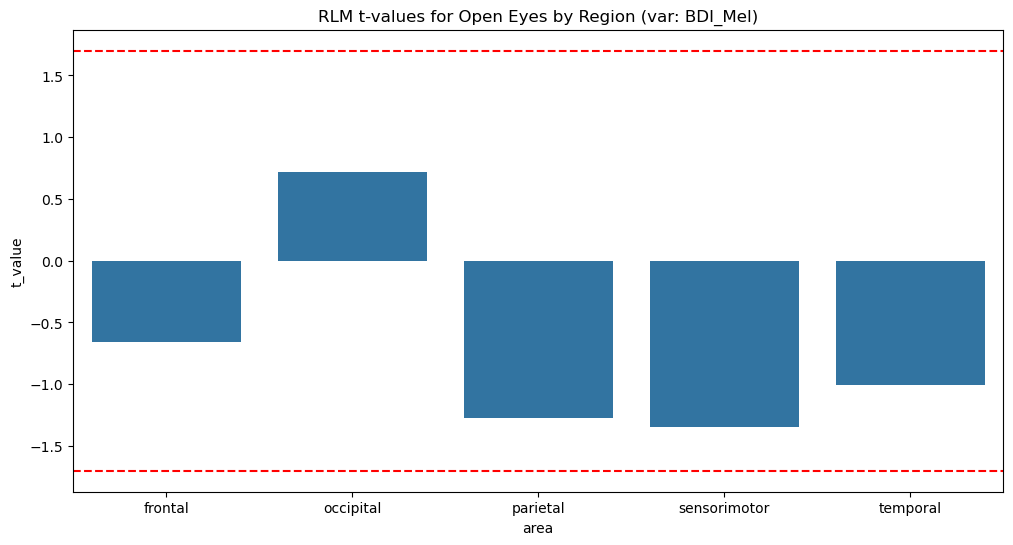

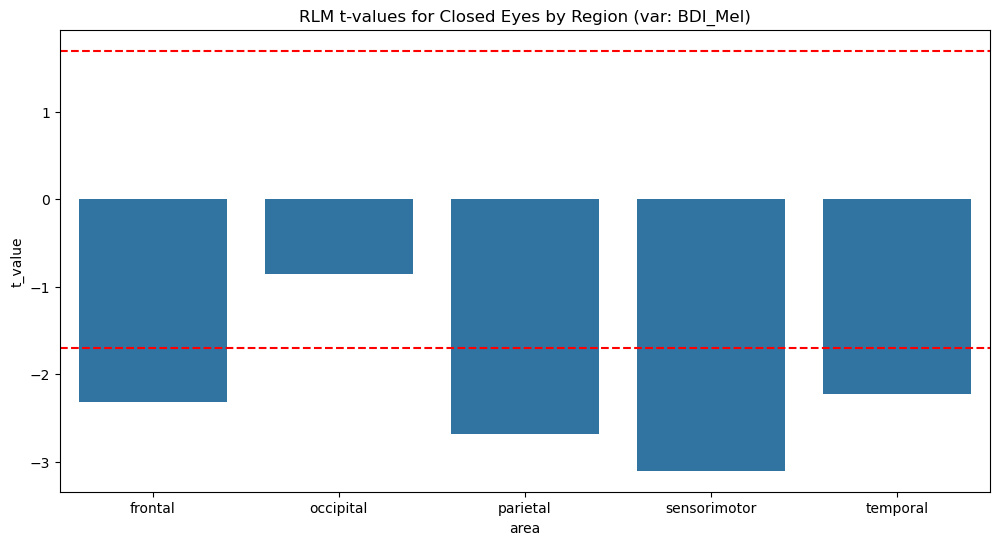

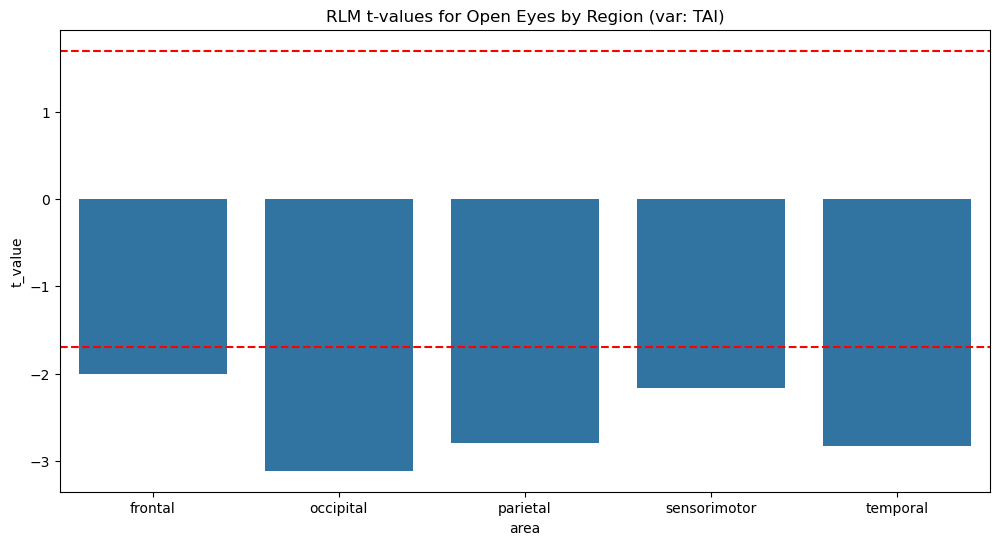

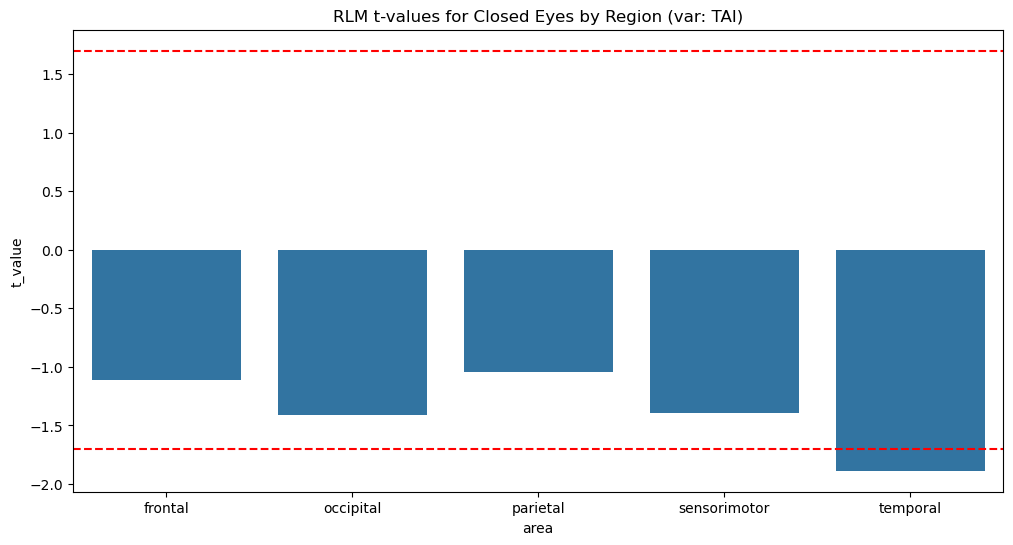

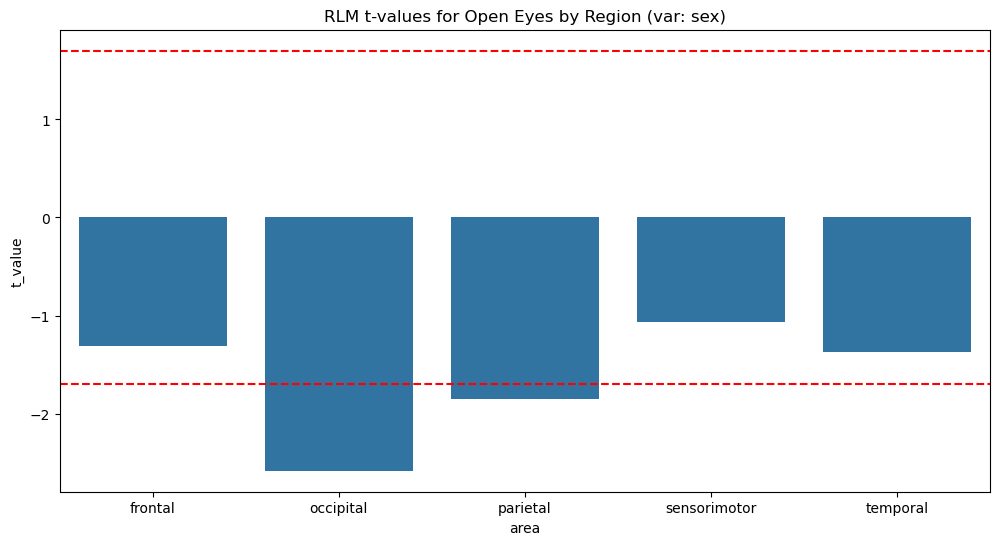

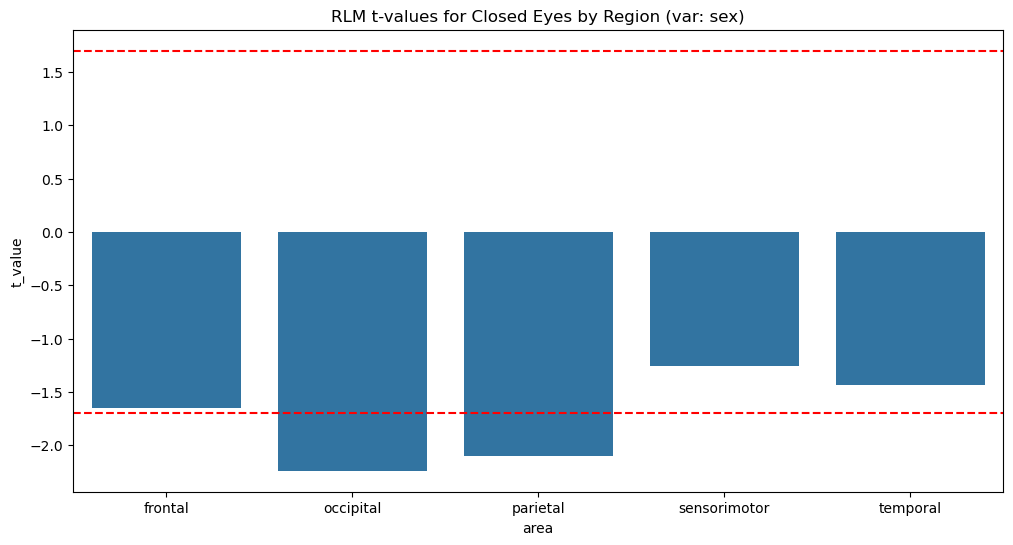

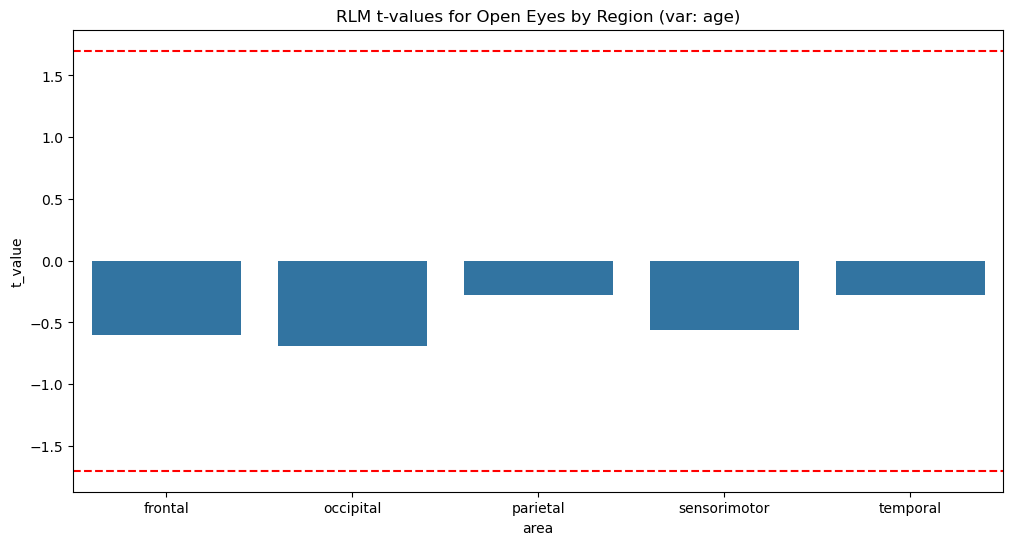

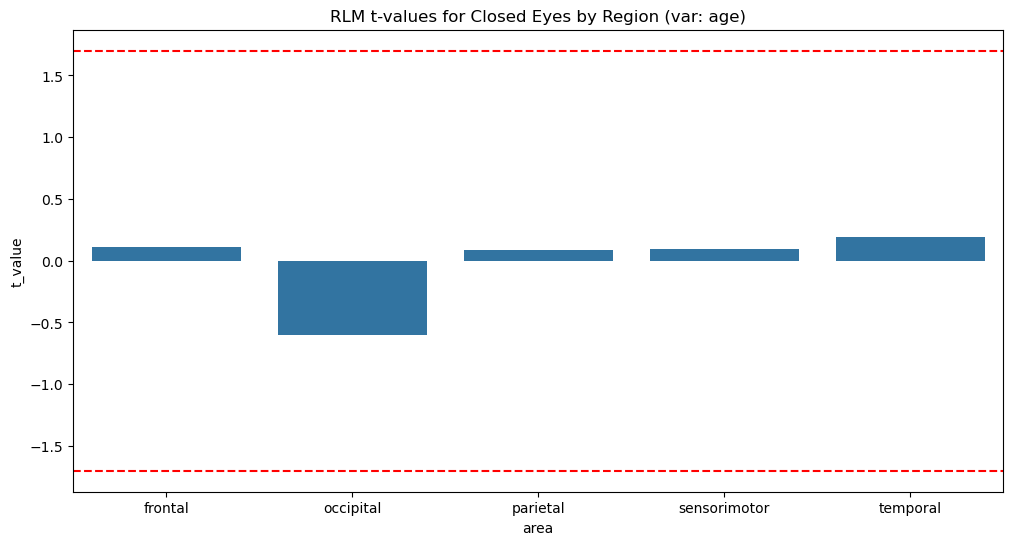

In [55]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['area'].isin(region_map.keys()))],
                x='area', y='t_value', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Region (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()

for var in variables:
    if var in ['intercept', 'age_squared']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)